# Predicting Car Prices

In this project, we will use the k-nearest neighbors algorithm to predict a car's market price using different features.  Additional information on this data is available [here](https://archive.ics.uci.edu/ml/datasets/automobile).  The data for this dataset is available [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data).

In [1]:
# imports
import numpy as np
import pandas as pd
# show more columns by default
pd.set_option('display.max_columns', 30)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

## Introduction

Let's begin by reading in our data, and setting up our dataframe for our analysis.  We will also want to understand what data is included in our dataset.

In [2]:
# read in data, but original data file has no header row
cars = pd.read_csv('imports-85.data', header=None)
cars.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
# add the header row to our data, with names given in the documentation
# replace - with _ in the column names
cars.columns = ['symboling', 'normalized_losses', 'make', 'fuel_type',
                'aspiration', 'num_of_doors', 'body_style', 'drive_wheels',
                'engine_location', 'wheel_base', 'length', 'width', 'height',
                'curb_weight', 'engine_type', 'num_of_cylinders',
                'engine_size', 'fuel_system', 'bore', 'stroke',
                'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
                'highway_mpg', 'price']

In [4]:
# review data now with headers
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Below is a summary of the data we have in each of the columns.

1. symboling - actuarial ranking of risk, with +3 as risky and -3 as pretty safe
2. normalized_losses - losses from 65 to 256
3. make - make of the car
4. fuel_type - diesel or gas
5. aspiration - standard or turbo
6. num_of_doors - two or four
7. body_style - hardtop, wagon, sedan, hatchback, or convertible
8. drive_wheels - front-wheel drive (fwd), rear-wheel drive (rwd), or four-wheel drive (4wd)
9. engine_location - front or rear
10. wheel_base - distance between the front and rear wheels 
11. length - measurement of length of the car
12. width - measurement of width of the car
13. height - measurement of height of the car
14. curb_weight - weight of the car, without passengers or cargo
15. engine_type - double overhead cam (dohc), dohcv (double overhead cam and valve), l (L engine), overhead cam (ohc), overhead cam and valve F (ohcf), overhead cam and valve (ohcv), or rotary engine (rotor)
16. num_of_cylinders - 2, 3, 4, 5, 6, 8, or 12
17. engine_size - measure of the displacement of the engine
18. fuel_system - 1 barrel carburetor (1bbl), 1 barrel carburetor (2bbl), 4 barrel carburetor (4bbl), indirect fuel injection (idi), multi-port fuel injection (mfi), multi point fuel injection (mpfi), throttle body indirect injection (spdi), sequential port fuel injection (spfi)
19. bore - diameter of the cylinder the piston travels
20. stroke - length of travel of the piston
21. compression_ratio - ratio of the engine volume when the piston is at the bottom to when it is at the top
22. horsepower - the power the engine produces
23. peak_rpm - maximum revolution per minute of the crankshaft
24. city_mpg - expected miles per gallon in city driving
25. highway_mpg - expected miles per gallon in highway driving
26. price - market price of the car

For our purposes, we will want to focus on `price`, our target variable, and other numeric columns for the features.  The available features are listed below:
- normalized_losses
- wheel_base
- length
- width
- height
- curb_weight
- engine_size
- bore
- stroke
- compression_ratio
- horsepower
- peak_rpm
- city_mpg
- highway_mpg

In [5]:
# create numeric-only dataframe
cols_numeric = ['price', 'normalized_losses', 'wheel_base', 'length', 'width', 
                'height', 'curb_weight', 'engine_size', 'bore', 'stroke',
                'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
                'highway_mpg']
cars_numeric = cars[cols_numeric]
cars_numeric.head()

,price,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,13495,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,16500,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,16500,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26
3,13950,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30
4,17450,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22


## Data Cleaning

From the documentation on the data, missing values are denoted with a "?" in the data.  We need to update these to `nan` so we can work with them, and then update any columns with "?" to numeric (having the "?" meant that the columns were cast as strings instead).

We will then look at all of the columns that contain missing data.  We cannot have missing values in our data for this work, so we will need to do one of the following:
- Supply a value, such as the mean or median value
- Drop the rows with missing values
- Drop the entire column

Finally, we will normalize all of our remaining columns so that the values range from 0 to 1.

In [6]:
# replace the ? with nan
cars_numeric = cars_numeric.replace(to_replace='?', value=np.nan)
cars_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
price                201 non-null object
normalized_losses    164 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_size          205 non-null int64
bore                 201 non-null object
stroke               201 non-null object
compression_ratio    205 non-null float64
horsepower           203 non-null object
peak_rpm             203 non-null object
city_mpg             205 non-null int64
highway_mpg          205 non-null int64
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


It appears we have missing values in the following columns:
- price
- normalized_losses
- bore
- stroke
- horsepower
- peak_rpm

These columns also need to be converted to integers or floats.

In [7]:
# convert to float
cars_numeric = cars_numeric.astype('float')

In [8]:
# price - since this is our target, let's drop any rows missing price
cars_numeric = cars_numeric.dropna(subset=['price'])

# review state of remaining data
cars_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 15 columns):
price                201 non-null float64
normalized_losses    164 non-null float64
wheel_base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb_weight          201 non-null float64
engine_size          201 non-null float64
bore                 197 non-null float64
stroke               197 non-null float64
compression_ratio    201 non-null float64
horsepower           199 non-null float64
peak_rpm             199 non-null float64
city_mpg             201 non-null float64
highway_mpg          201 non-null float64
dtypes: float64(15)
memory usage: 25.1 KB


In [9]:
# horsepower and peak_rpm - only have 2 missing values, let's drop these
# bore and stroke - only have 4 missing values, let's drop these
cars_numeric = cars_numeric.dropna(subset=['horsepower', 'peak_rpm', 
                                           'bore', 'stroke'])

# review state of remaining data
cars_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 15 columns):
price                195 non-null float64
normalized_losses    160 non-null float64
wheel_base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb_weight          195 non-null float64
engine_size          195 non-null float64
bore                 195 non-null float64
stroke               195 non-null float64
compression_ratio    195 non-null float64
horsepower           195 non-null float64
peak_rpm             195 non-null float64
city_mpg             195 non-null float64
highway_mpg          195 non-null float64
dtypes: float64(15)
memory usage: 24.4 KB


In [10]:
# normalized_losses - still has 35 missing values
cars_numeric['normalized_losses'].describe()

count    160.000000
mean     121.300000
std       35.602417
min       65.000000
25%       94.000000
50%      114.000000
75%      148.000000
max      256.000000
Name: normalized_losses, dtype: float64

In [11]:
# let's replace the missing values with the median value
cars_numeric = cars_numeric.fillna(cars_numeric.median())

In [12]:
# confirm no missing values remain
cars_numeric.isnull().sum()

price                0
normalized_losses    0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_size          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
dtype: int64

In [13]:
# review data
cars_numeric.describe()

,price,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,13248.015385,119.989744,98.896410,174.256923,65.886154,53.861538,2559.000000,127.938462,3.329385,3.250308,10.194974,103.271795,5099.487179,25.374359,30.841026
std,8056.330093,32.353395,6.132038,12.476443,2.132484,2.396778,524.715799,41.433916,0.271866,0.314115,4.062109,37.869730,468.271381,6.401382,6.829315
min,5118.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000
25%,7756.500000,96.500000,94.500000,166.300000,64.050000,52.000000,2145.000000,98.000000,3.150000,3.110000,8.500000,70.000000,4800.000000,19.500000,25.000000
50%,10245.000000,114.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000
75%,16509.000000,135.500000,102.400000,184.050000,66.900000,55.650000,2943.500000,145.500000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,35.000000
max,45400.000000,256.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000


In [14]:
# normalize all of the columns except price so values range between zero and one
# subtract min (lowest value 0) and then divide by difference between max and min (highest value 1)
prices = cars_numeric['price']
cars_numeric = (cars_numeric - cars_numeric.min()) / (cars_numeric.max() - cars_numeric.min())
cars_numeric['price'] = prices
cars_numeric.describe()

,price,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,13248.015385,0.287904,0.358496,0.494879,0.477449,0.505128,0.415438,0.252598,0.563846,0.562051,0.199686,0.258279,0.387546,0.343732,0.390553
std,8056.330093,0.169390,0.178777,0.186216,0.182264,0.199731,0.203536,0.156354,0.194190,0.149578,0.253882,0.176961,0.191131,0.177816,0.179719
min,5118.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7756.500000,0.164921,0.230321,0.376119,0.320513,0.350000,0.254849,0.139623,0.435714,0.495238,0.093750,0.102804,0.265306,0.180556,0.236842
50%,10245.000000,0.256545,0.303207,0.479104,0.435897,0.525000,0.359193,0.222642,0.550000,0.580952,0.125000,0.219626,0.387755,0.333333,0.368421
75%,16509.000000,0.369110,0.460641,0.641045,0.564103,0.654167,0.564585,0.318868,0.750000,0.638095,0.150000,0.317757,0.551020,0.472222,0.500000
max,45400.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Univariate Models

To begin, we will examine univariate models.

We will create a function to split the data into training and testing sets, fit the k-nearest neighbors model on the training dataset, make predictions, and then calculate the RMSE.

We will then use this function to train and test models using different features.

We will then modify this function to compute the RMSE for multiple values of k, rather than only using the default of five.  We can then review the results for each feature using various values of k.

In [15]:
# create the function
def knn_train_test(feature, target, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    # shuffle the data before splitting between train and test
    rand_index = np.random.permutation(df.index)
    rand_df = df.reindex(rand_index)
    
    # create train and test
    n = len(df[target]) // 2
    train = rand_df.iloc[:n]
    test = rand_df.iloc[n:]
    
    # fit and predict
    knn.fit(train[[feature]], train[target])
    predictions = knn.predict(test[[feature]])
    
    # calc root mean squared error
    rmse = mean_squared_error(test[target], predictions) ** (1/2)
    
    return rmse

In [16]:
# train a model on each of the columns and collect rmse

# collect all of the feature columns
feature_cols = cars_numeric.columns.drop('price')
# create a dictionary to store the rmse for each feature model
univariate_rmse = {}

# use the function to calc rmse for each feature
for col in feature_cols:
    rmse = knn_train_test(col, 'price', cars_numeric)
    univariate_rmse[col] = rmse

# create series from dictionary
univariate_rmse_series = pd.Series(univariate_rmse)
univariate_rmse_series.sort_values()

engine_size          4206.269209
highway_mpg          4409.808046
city_mpg             4437.412782
horsepower           4543.271115
curb_weight          4594.668401
width                4934.118152
length               5210.375156
wheel_base           5692.794469
compression_ratio    7020.882648
bore                 7076.775614
normalized_losses    7125.094737
stroke               7217.395544
peak_rpm             7313.971818
height               7574.683028
dtype: float64

For the default k value of 5, the model had the lowest RMSE when using `engine_size` as the single feature, although `highway_mpg`, `city_mpg`, `horsepower`, and `curb_weight` were also relatively low.

In [17]:
# modify our function to use multiple values for k

def knn_train_test_ks(feature, target, df):
    np.random.seed(1)
    
    # shuffle the data before splitting between train and test
    rand_index = np.random.permutation(df.index)
    rand_df = df.reindex(rand_index)
    
    # create train and test
    n = len(df[target]) // 2
    train = rand_df.iloc[:n]
    test = rand_df.iloc[n:]
    
    # create list of k values and dictionary to store results
    ks = [1, 3, 5, 7, 9]
    k_rmse = {}
    
    # fit, predict, and calc rmse for each k
    for k in ks:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train[[feature]], train[target])
        predictions = knn.predict(test[[feature]])
        rmse = mean_squared_error(test[target], predictions) ** (1/2)
        k_rmse[k] = rmse  
    
    return k_rmse

In [18]:
# train a model on each of the columns and collect rmse's for each k

# create a dictionary to store the rmse's for each feature model
univariate_rmse_ks = {}

# use the function to calc rmse for each feature
for col in feature_cols:
    rmse = knn_train_test_ks(col, 'price', cars_numeric)
    univariate_rmse_ks[col] = rmse

# view dictionary of dictionaries
univariate_rmse_ks

{'bore': {1: 9782.241055679857,
  3: 6987.841188454177,
  5: 7076.77561366209,
  7: 7604.132316795714,
  9: 7654.952689987121},
 'city_mpg': {1: 5622.607820583046,
  3: 4206.80832744432,
  5: 4437.412782379445,
  7: 4599.831016942161,
  9: 4520.10890409878},
 'compression_ratio': {1: 7083.660420939422,
  3: 6717.9716151019275,
  5: 7020.882647516912,
  7: 6879.383359042175,
  9: 7206.35504394561},
 'curb_weight': {1: 6739.432537578474,
  3: 5187.904039397362,
  5: 4594.66840143918,
  7: 4125.28829394039,
  9: 4175.967095661961},
 'engine_size': {1: 4467.786289263467,
  3: 4385.693565692226,
  5: 4206.26920945973,
  7: 4174.278109733596,
  9: 4059.1258836142865},
 'height': {1: 9144.689129517208,
  3: 8163.539469846211,
  5: 7574.683028055379,
  7: 7909.810658286173,
  9: 7609.841226601191},
 'highway_mpg': {1: 5591.286916046342,
  3: 4674.102996268684,
  5: 4409.808045940415,
  7: 4269.119331662173,
  9: 4234.824050221162},
 'horsepower': {1: 4333.419203100009,
  3: 4581.258594235456,


In [19]:
uni_rmse = pd.DataFrame(index=[1,3,5,7,9], columns=feature_cols)
for k,v in univariate_rmse_ks.items():   
    for kvalue, rmse in v.items():
        uni_rmse[k][kvalue] = rmse
        
uni_rmse.head()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
1,7712.94,5718.71,5294.12,6247.14,9144.69,6739.43,4467.79,9782.24,7395.42,7083.66,4333.42,6920.34,5622.61,5591.29
3,7449.65,5718.48,5152.08,5419.04,8163.54,5187.9,4385.69,6987.84,7098.71,6717.97,4581.26,7140.7,4206.81,4674.1
5,7125.09,5692.79,5210.38,4934.12,7574.68,4594.67,4206.27,7076.78,7217.4,7020.88,4543.27,7313.97,4437.41,4409.81
7,7179.91,5725.91,5380.41,4520.04,7909.81,4125.29,4174.28,7604.13,7620.37,6879.38,4784.71,7285.09,4599.83,4269.12
9,7246.4,5840.8,5345.18,4469.77,7609.84,4175.97,4059.13,7654.95,7436.3,7206.36,4757.01,7239.11,4520.11,4234.82


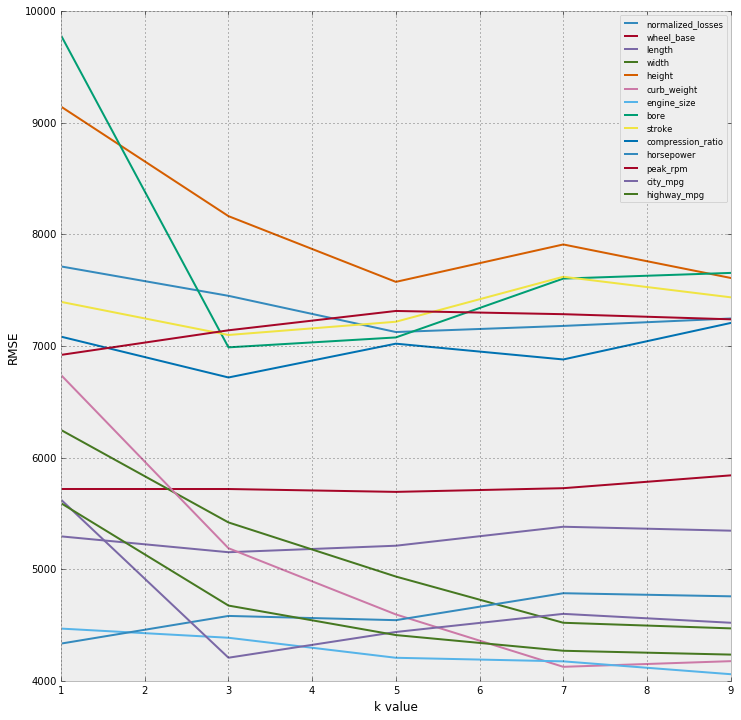

In [20]:
# create visualization for univariate_rmse_ks

plt.figure(figsize=(12,12))
for col in feature_cols:
    plt.plot(uni_rmse.index, uni_rmse[[col]], label=col)
plt.xlabel('k value')
plt.ylabel('RMSE')

plt.legend(fontsize = 'small')
plt.show()

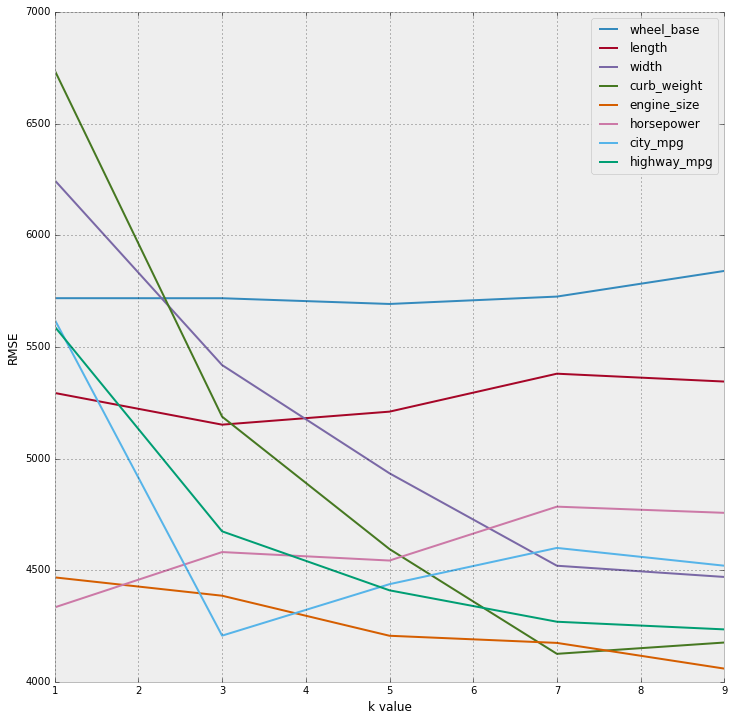

In [21]:
# the above contains too many features to review
# let's look at the better performing ones only

plt.figure(figsize=(12,12))
for col in feature_cols:
    if uni_rmse[col][5] < 6000:
        plt.plot(uni_rmse.index, uni_rmse[[col]], label=col)
plt.xlabel('k value')
plt.ylabel('RMSE')

plt.legend(fontsize = 'large')
plt.show()

As k increases, it appears that `engine_size`, `curb_weight`, and `highway_mpg` have the lowest RMSEs.

Note that `curb_weight` starts out relatively high when k = 1, but decreases quickly as k increases.  On the other hand, for `engine_size`, the reduction in RMSE starts out relatively low and decreases less dramatically.

From all of these iterations, `engine_size` at k = 9 achieves the lowest RMSE of 4059.13.

## Multivariate Models

Next, let's look at some multivariate models.  We can modify the function we wrote previously to take multiple features instead of just one.  We can also use the best features from the previous step to determine which features we want to combine in our multivariate models.

Let's investigate models with two, three, four, and five features, using the best features we found above.  To determine which features are best, we will use those with the lowest average RSME across the five k values we used.

To start with, we will only use the default k value of five and work on tuning this later.

In [22]:
# determine the best features
uni_rmse.mean().sort_values()

engine_size          4258.630612
horsepower           4599.933166
highway_mpg          4635.828268
city_mpg             4677.353770
curb_weight          4964.652074
width                5118.020804
length               5276.431316
wheel_base           5739.338933
compression_ratio    6981.650617
peak_rpm             7179.842705
normalized_losses    7342.801364
stroke               7353.638813
bore                 7821.188573
height               8080.512702
dtype: float64

In [23]:
# determine our feature groups
best_two = ['engine_size', 'horsepower']
best_three = ['engine_size', 'horsepower', 'highway_mpg']
best_four = ['engine_size', 'horsepower', 'highway_mpg', 'city_mpg']
best_five = ['engine_size', 'horsepower', 'highway_mpg', 'city_mpg', 'curb_weight']

In [24]:
# update our function
def knn_train_test_mult(features, target, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    # shuffle the data before splitting between train and test
    rand_index = np.random.permutation(df.index)
    rand_df = df.reindex(rand_index)
    
    # create train and test
    n = len(df[target]) // 2
    train = rand_df.iloc[:n]
    test = rand_df.iloc[n:]
    
    # fit and predict
    knn.fit(train[features], train[target])
    predictions = knn.predict(test[features])
    
    # calc root mean squared error
    rmse = mean_squared_error(test[target], predictions) ** (1/2)
    
    return rmse

In [25]:
# create a dictionary to store the rmse for each model
multivariate_rmse = {}

# use the function to calc rmse for each feature group
multivariate_rmse['best_two'] = knn_train_test_mult(best_two, 'price', cars_numeric)
multivariate_rmse['best_three'] = knn_train_test_mult(best_three, 'price', cars_numeric)
multivariate_rmse['best_four'] = knn_train_test_mult(best_four, 'price', cars_numeric)
multivariate_rmse['best_five'] = knn_train_test_mult(best_five, 'price', cars_numeric)

# create series from dictionary
multivariate_rmse_series = pd.Series(multivariate_rmse)
multivariate_rmse_series.sort_values()

best_two      3300.015846
best_three    3461.247255
best_four     3527.352174
best_five     3801.394037
dtype: float64

### Best Features?

We picked our best features based on the average RMSE across the five k values we looked at above.  However, are these really the best features?

We can focus in on the better performing features (those at the bottom of the second graph) which seem to have lower RMSE's than the other features.  Let's look more closely at what the best features might by focusing on a subset of the available features:
- `width`
- `curb_weight`
- `engine_size`
- `horsepower`
- `city_mpg`
- `highway_mpg`

In [26]:
# look at best five
five_one = ['curb_weight', 'engine_size', 'horsepower', 'city_mpg', 'highway_mpg']
five_two = ['width', 'engine_size', 'horsepower', 'city_mpg', 'highway_mpg']
five_three = ['width', 'curb_weight', 'horsepower', 'city_mpg', 'highway_mpg']
five_four = ['width', 'curb_weight', 'engine_size', 'city_mpg', 'highway_mpg']
five_five = ['width', 'curb_weight', 'engine_size', 'horsepower', 'highway_mpg']
five_six = ['width', 'curb_weight', 'engine_size', 'horsepower', 'city_mpg']

In [27]:
# create a dictionary to store the rmse for each model
best_five_rmse = {}

# use the function to calc rmse for each feature group
best_five_rmse['five_one'] = knn_train_test_mult(five_one, 'price', cars_numeric)
best_five_rmse['five_two'] = knn_train_test_mult(five_two, 'price', cars_numeric)
best_five_rmse['five_three'] = knn_train_test_mult(five_three, 'price', cars_numeric)
best_five_rmse['five_four'] = knn_train_test_mult(five_four, 'price', cars_numeric)
best_five_rmse['five_five'] = knn_train_test_mult(five_five, 'price', cars_numeric)
best_five_rmse['five_six'] = knn_train_test_mult(five_six, 'price', cars_numeric)

# create series from dictionary
best_five_rmse_series = pd.Series(best_five_rmse)
best_five_rmse_series.sort_values()

five_four     3481.539406
five_two      3641.868742
five_three    3730.970922
five_six      3777.412916
five_five     3789.590624
five_one      3801.394037
dtype: float64

When we picked the best five features from the average RMSE, we got 3801, which was actually the worst of the six groups of five features we tested.  The best group of five features here was actually `width`, `curb_weight`, `engine_size`, `city_mpg`, and `highway_mpg`, instead of `curb_weight`, `engine_size`, `horsepower`, `city_mpg`, and `highway_mpg`.

In [28]:
# look at best four features (this will be many more combos)
four_one = ['engine_size', 'horsepower', 'city_mpg', 'highway_mpg']
four_two = ['curb_weight', 'horsepower', 'city_mpg', 'highway_mpg']
four_three = ['curb_weight', 'engine_size', 'city_mpg', 'highway_mpg']
four_four = ['curb_weight', 'engine_size', 'horsepower', 'highway_mpg']
four_five = ['curb_weight', 'engine_size', 'horsepower', 'city_mpg']
four_six = ['width', 'horsepower', 'city_mpg', 'highway_mpg']
four_seven = ['width', 'engine_size', 'city_mpg', 'highway_mpg']
four_eight = ['width', 'engine_size', 'horsepower', 'highway_mpg']
four_nine = ['width', 'engine_size', 'horsepower', 'city_mpg']
four_ten = ['width', 'curb_weight', 'city_mpg', 'highway_mpg']
four_eleven = ['width', 'curb_weight', 'horsepower', 'highway_mpg']
four_twelve = ['width', 'curb_weight', 'horsepower', 'city_mpg']
four_thirteen = ['width', 'curb_weight', 'engine_size', 'highway_mpg']
four_fourteen = ['width', 'curb_weight', 'engine_size', 'city_mpg']
four_fifteen = ['width', 'curb_weight', 'engine_size', 'horsepower']

In [29]:
# create a dictionary to store the rmse for each model
best_four_rmse = {}

# use the function to calc rmse for each feature group
best_four_rmse['four_one'] = knn_train_test_mult(four_one, 'price', cars_numeric)
best_four_rmse['four_two'] = knn_train_test_mult(four_two, 'price', cars_numeric)
best_four_rmse['four_three'] = knn_train_test_mult(four_three, 'price', cars_numeric)
best_four_rmse['four_four'] = knn_train_test_mult(four_four, 'price', cars_numeric)
best_four_rmse['four_five'] = knn_train_test_mult(four_five, 'price', cars_numeric)
best_four_rmse['four_six'] = knn_train_test_mult(four_six, 'price', cars_numeric)
best_four_rmse['four_seven'] = knn_train_test_mult(four_seven, 'price', cars_numeric)
best_four_rmse['four_eight'] = knn_train_test_mult(four_eight, 'price', cars_numeric)
best_four_rmse['four_nine'] = knn_train_test_mult(four_nine, 'price', cars_numeric)
best_four_rmse['four_ten'] = knn_train_test_mult(four_ten, 'price', cars_numeric)
best_four_rmse['four_eleven'] = knn_train_test_mult(four_eleven, 'price', cars_numeric)
best_four_rmse['four_twelve'] = knn_train_test_mult(four_twelve, 'price', cars_numeric)
best_four_rmse['four_thirteen'] = knn_train_test_mult(four_thirteen, 'price', cars_numeric)
best_four_rmse['four_fourteen'] = knn_train_test_mult(four_fourteen, 'price', cars_numeric)
best_four_rmse['four_fifteen'] = knn_train_test_mult(four_fifteen, 'price', cars_numeric)

# create series from dictionary
best_four_rmse_series = pd.Series(best_four_rmse)
best_four_rmse_series.sort_values()

four_fourteen    3482.154255
four_twelve      3513.096562
four_one         3527.352174
four_eleven      3586.360741
four_eight       3649.359989
four_thirteen    3655.264952
four_six         3699.300675
four_seven       3709.037061
four_nine        3739.894508
four_two         3772.972621
four_ten         3796.475357
four_four        3837.171464
four_five        3848.112854
four_fifteen     3908.677302
four_three       3985.051938
dtype: float64

Again we see that the one we picked from the averages as the best four wasn't the best combination.  Instead, it appears that `width`, `curb_weight`, `engine_size`, and `city_mpg` were the best, instead of `engine_size`, `horsepower`, `highway_mpg`, and `city_mpg`.

If we wanted to look at all of the features available and perform a grid search, we would instead want to write a function to search through all of the possible combinations for the given number of features and calculate the RMSE for each combination, returning the best combination (with the lowest RMSE) for that number of features.

## Tuning the Value of k

We will now look further at the four and five feature models and determine the optimal value for k in the range of 1 to 25.

To do this, we will modify our function to evaluate different k values and then plot the results.

In [30]:
# modify our function to be multivariate and use multiple values for k

def knn_train_test_multi_ks(features, target, df):
    np.random.seed(1)
    
    # shuffle the data before splitting between train and test
    rand_index = np.random.permutation(df.index)
    rand_df = df.reindex(rand_index)
    
    # create train and test
    n = len(df[target]) // 2
    train = rand_df.iloc[:n]
    test = rand_df.iloc[n:]
    
    # create list of k values and dictionary to store results
    ks = [i for i in range(1,26)]
    k_rmse = {}
    
    # fit, predict, and calc rmse for each k
    for k in ks:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train[features], train[target])
        predictions = knn.predict(test[features])
        rmse = mean_squared_error(test[target], predictions) ** (1/2)
        k_rmse[k] = rmse  
    
    return k_rmse

In [31]:
# best models
four_model = four_fourteen
five_model = five_four

In [32]:
# use the function to calc rmse's for the four-feature models
four_model_rmse = knn_train_test_multi_ks(four_model, 'price', cars_numeric)
four_model_rmse_series = pd.Series(four_model_rmse)
four_model_rmse_series.sort_values()

4     3320.352151
3     3358.468678
2     3435.944595
5     3482.154255
1     3530.405421
6     3567.440189
7     3606.501609
8     3684.220463
9     3791.815901
10    3895.558714
12    3943.906062
11    3947.077840
13    4004.818865
14    4079.841119
15    4171.936063
16    4228.387911
17    4280.599671
18    4348.673750
19    4374.544183
25    4406.627364
20    4416.721543
21    4439.682594
24    4440.132712
23    4458.945562
22    4473.408473
dtype: float64

In [33]:
# use the function to calc rmse's for the five-feature models
five_model_rmse = knn_train_test_multi_ks(five_model, 'price', cars_numeric)
five_model_rmse_series = pd.Series(five_model_rmse)
five_model_rmse_series.sort_values()

4     3339.338043
3     3458.400538
5     3481.539406
1     3481.872933
6     3561.565680
7     3597.779572
2     3662.780899
8     3770.198170
9     3882.605765
10    3954.669142
12    4021.562418
11    4037.059361
13    4039.812531
14    4141.805764
15    4226.654778
16    4288.633573
17    4328.206909
18    4368.377931
21    4416.858003
19    4418.369306
20    4430.782726
22    4433.229714
23    4448.678397
24    4461.305296
25    4461.797183
dtype: float64

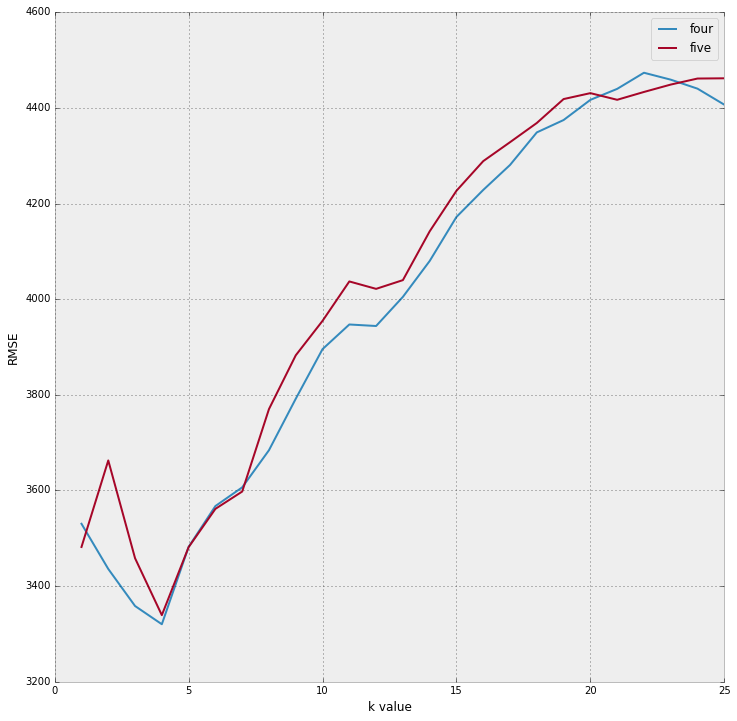

In [34]:
# create a plot of the RMSEs for the two models
x4 = list(four_model_rmse.keys())
y4 = list(four_model_rmse.values())
x5 = list(five_model_rmse.keys())
y5 = list(five_model_rmse.values())

plt.figure(figsize=(12,12))
plt.plot(x4, y4, label='four')
plt.plot(x5, y5, label='five')

plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In both cases, it appears that the optimal value for k is four.  Above that, the RMSE steadily increases.

## k-fold Cross Validation

Let's make one more modification to our function.  Instead of using the test/train validation, let's use the k-fold cross validation instead and see how our results compare.  For this investigation, we will use 10 as the number of folds (the standard number of folds).

We will use our best features we identified above (`four_model` and `five_model`) and we will use 4 as the number of neighbors.

In [35]:
# modify our function to use k-fold cross validation

def knn_cross(features, target, df):
    kf = KFold(10, shuffle=True, random_state=1)
    knn = KNeighborsRegressor(n_neighbors=4)
    mses = cross_val_score(knn, df[features], df[target], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    return avg_rmse

In [36]:
# use the function to calc rmse for the four-feature model
four_model_rmse_cross = knn_cross(four_model, 'price', cars_numeric)
four_model_rmse_cross

2834.972254292872

In [37]:
# use the function to calc rmse for the five-feature model
five_model_rmse_cross = knn_cross(five_model, 'price', cars_numeric)
five_model_rmse_cross

2947.444399045995

In both cases, the RMSE is lower when we use k-fold cross validation than when we use the train/test validation.  This is because with k-fold cross validation, we train the model on more of the data (9/10ths of the data each time we run the model rather than half of the data run once).